# Libraries

In [42]:
import requests

import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval

pd.set_option('display.max_columns', None) # display all columns in DF

# Uploading raw data

In [43]:
df_openFDA_NDC = pd.read_csv('raw_openFDA_NDC_data.csv', sep = '~')
df_medicaid = pd.read_csv('raw_medicaid_data.csv', sep = '~')
df_PPI = pd.read_excel('PPI industry data for Pharmaceutical preparation manufacturing.xlsx', skiprows = 10)
df_NIH = pd.read_csv('nih_data.csv', sep = '~')

# Data manipulation: Raw data

### OpenFDA NDC

Clearing nda

In [44]:
df_openFDA_NDC['NDA #'] = df_openFDA_NDC['application_number'].str.replace(r'\D', '')
df_openFDA_NDC['NDA #'] = pd.to_numeric(df_openFDA_NDC['NDA #'])

### Medicaid

Clearing labeler and product code

In [45]:
df_medicaid['labeler_code'] = pd.to_numeric(df_medicaid['labeler_code'])
df_medicaid['product_code'] = pd.to_numeric(df_medicaid['product_code'])

Creating a date

In [46]:
df_medicaid['date'] = 'Q' + df_medicaid['quarter'].astype(str) + ' ' + df_medicaid['year'].astype(str)
df_medicaid['date'] = pd.to_datetime(df_medicaid['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

### PPI

Creating a date

In [47]:
df_PPI['Period'] = df_PPI['Period'].str.replace(r'\D', '')
df_PPI['Period'] = pd.to_numeric(df_PPI['Period'])
df_PPI['day'] = 1
df_PPI['date'] = pd.to_datetime(dict(year = df_PPI['Year'], month = df_PPI['Period'], day= df_PPI['day']))

Calculating PPI multiplier

In [48]:
df_PPI['Value'] = pd.to_numeric(df_PPI['Value'])
df_PPI['PPI_multiplier'] = df_PPI['Value'].iloc[-1] / df_PPI['Value']

### NIH

Selecting only Established Pharmacologic Class (EPC)

In [49]:
df_NIH = df_NIH.loc[df_NIH['rxclassMinConceptItem.classType'] == 'EPC']
df_NIH = df_NIH[['minConcept.name', 'rxclassMinConceptItem.className']]
df_NIH = df_NIH.rename(columns = {'minConcept.name': 'generic_name', 'rxclassMinConceptItem.className': 'EPC'})

# Merging raw data

### Medicaid and PPI

In [50]:
df_medicaid = pd.merge(df_medicaid, df_PPI, on = 'date', how = 'left')

Adjusting for inflation

In [51]:
df_medicaid['total_amount_reimbursed_adj'] = df_medicaid['total_amount_reimbursed'] * df_medicaid['PPI_multiplier']
df_medicaid['price_per_unit_adj'] = df_medicaid['price_per_unit'] * df_medicaid['PPI_multiplier']

Deleting redundant columns

In [52]:
df_medicaid = df_medicaid.drop(columns=['Series ID', 'Year', 'Period', 'Value', 'Unnamed: 4', 'Unnamed: 5', 'day', 'PPI_multiplier'])

### OpenFDA and Medicaid

In [53]:
df_medicaid_openFDA = pd.merge(df_medicaid, df_openFDA_NDC, on = ['labeler_code', 'product_code'], how = 'inner')

### OpenFDA, Medicaid and NIH

In [54]:
df_consolidation_data = pd.merge(df_medicaid_openFDA, df_NIH, on = ['generic_name'], how = 'left')

<p style="color:red">Issue: We are only able add EPC to a small sample size.</p>

In [55]:
print(len(df_consolidation_data))
print(len(df_consolidation_data['EPC'].dropna()))

650875
87002


# Raw output

Calculating the average across drug strength 

In [56]:
df_consolidation_data = df_consolidation_data.set_index(['date', 'unique_id', 'marketing_category', 'brand_name', 'generic_name', 'labeler_name', 'is_original_packager']).groupby(level = ['date', 'unique_id', 'marketing_category', 'brand_name', 'generic_name', 'labeler_name', 'is_original_packager'])[['units_reimbursed', 'total_amount_reimbursed_adj', 'price_per_unit_adj']].agg('mean')
df_consolidation_data = df_consolidation_data.reset_index()

# Downloading raw output

In [58]:
df_consolidation_data.to_csv('raw_consolidation_data.csv', sep = '~', index = False)

# Descriptive statistics

In [59]:
df = df_consolidation_data

In [60]:
df_temp = df.drop_duplicates(subset = ['labeler_name', 'unique_id'])
df_temp = df_temp.groupby(['marketing_category'])['unique_id'].count()
df_temp = df_temp.reset_index()
df_temp

,marketing_category,unique_id
0,ANDA,13675
1,BLA,443
2,NDA,4168
3,NDA AUTHORIZED GENERIC,833


Number of unique drugs

In [61]:
df_temp = df.drop_duplicates(subset = ['unique_id'])
len(df_temp)

8411

Number of entrance (event) for unique drugs

In [62]:
df = df_consolidation_data

In [63]:
df_temp = df.drop_duplicates(subset = ['labeler_name', 'unique_id'])
df_temp = df_temp.groupby(['marketing_category', 'unique_id'])['labeler_name'].count()
df_temp = df_temp.reset_index()
df_temp['entrance_count'] = pd.to_numeric(df_temp['labeler_name'])
df_temp['entrance_count'] = df_temp['entrance_count'] - 1
df_temp = df_temp.drop(columns = ['labeler_name'])
df_temp.sort_values(by = ['entrance_count'], ascending=False)

,marketing_category,unique_id,entrance_count
2187,ANDA,gabapentin-capsule-oral-300 mg/1,22
2186,ANDA,gabapentin-capsule-oral-100 mg/1,22
2188,ANDA,gabapentin-capsule-oral-400 mg/1,21
400,ANDA,"atorvastatin calcium-tablet, film coated-oral-...",16
2358,ANDA,hydrocodone bitartrate and acetaminophen-table...,16
...,...,...,...
5155,BLA,"(insulin degludec and liraglutide)-injection, ...",0
5154,BLA,"(coagulation factor ix (recombinant), glycopeg...",0
5150,ANDA,zolpidem tartrate-tablet-sublingual-3.5 mg/1,0
5149,ANDA,zolpidem tartrate-tablet-sublingual-1.75 mg/1,0


In [64]:
df_temp['entrance_count'].value_counts(bins = 17, sort = False)

(-0.023, 1.294]     8387
(1.294, 2.588]       608
(2.588, 3.882]       356
(3.882, 5.176]       439
(5.176, 6.471]       126
(6.471, 7.765]        67
(7.765, 9.059]       103
(9.059, 10.353]       33
(10.353, 11.647]      25
(11.647, 12.941]      13
(12.941, 14.235]      27
(14.235, 15.529]      10
(15.529, 16.824]       6
(16.824, 18.118]       0
(18.118, 19.412]       0
(19.412, 20.706]       0
(20.706, 22.0]         3
Name: entrance_count, dtype: int64

For BLA only

In [65]:
df_temp = df_temp[df_temp['marketing_category'] == 'BLA']

In [66]:
df_temp['entrance_count'].value_counts(bins = 4, sort = False)

(-0.003, 0.5]    392
(0.5, 1.0]        21
(1.0, 1.5]         0
(1.5, 2.0]         3
Name: entrance_count, dtype: int64

Number of companies

In [67]:
df = df_consolidation_data

In [68]:
df_temp = df.drop_duplicates(subset = ['labeler_name', 'unique_id'])
df_temp = df_temp.groupby(['labeler_name'])['labeler_name'].count()
df_temp.sort_values(ascending=False)

labeler_name
Aurobindo Pharma Limited               538
Teva Pharmaceuticals USA, Inc.         493
Mylan Pharmaceuticals Inc.             491
Actavis Pharma, Inc.                   440
Sun Pharmaceutical Industries, Inc.    398
                                      ... 
Chiasma Inc.                             1
Medimetriks Pharmaceuticals Inc          1
Medstone Pharma LLC                      1
Meitheal Pharmaceuticals Inc             1
MorphoSys US Inc.                        1
Name: labeler_name, Length: 852, dtype: int64

# First figure

In [73]:
df = df_consolidation_data

In [75]:
df_figure = df.loc[df['unique_id'] == 'olanzapine-tablet-oral-5 mg/1']

In [76]:
df_figure = df_figure.groupby(['date', 'generic_name', 'labeler_name'])['price_per_unit_adj'].mean()
df_figure = df_figure.reset_index()
df_figure['ln_price_per_unit_adj'] = np.log(df_figure['price_per_unit_adj'])

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Price Per Unit Adj. for Inflation'),
 Text(0.5, 1.0, 'Olanzapine')]

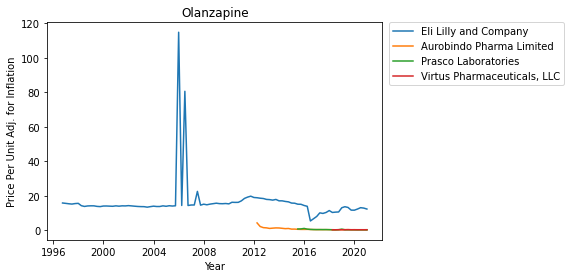

In [78]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0])

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Price Per Unit Adj. for Inflation'),
 Text(0.5, 1.0, 'Olanzapine')]

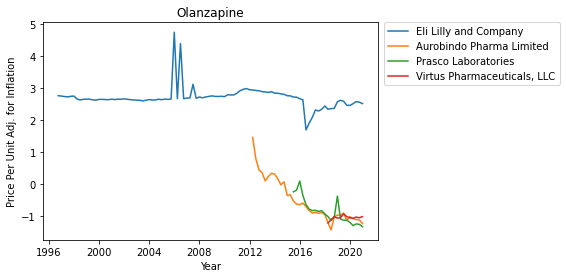

In [79]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'ln_price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit Adj. for Inflation', title = df_figure['generic_name'][0])

In [ ]:
df_figure.to_excel('output_for_one_drug.xlsx', index = False)